In [1]:
import numpy as np
import joblib
import os
import sqlite3
from copy import deepcopy
from tqdm.notebook import tqdm
from math import sqrt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind, f_oneway, wilcoxon

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

DOMAINS = ["amides", "sulfonamides", "ROH", "anilines", "heterocycles", "alkyl amines"]
DB_NAME='rxn_db.sql'

In [2]:
full_id = joblib.load('./array_joblibs/full_id_arrays_by_nuc.joblib')
full_desc = joblib.load('./array_joblibs/full_desc_arrays_by_nuc.joblib')
full_yield = joblib.load('./array_joblibs/full_y_arrays_by_nuc.joblib')

In [3]:
def split_by_elec(id_array_dict, 
                  domain_list=DOMAINS):
    '''Splits reaction arrays into those that employ...
    1) electrophile 1
    2) electrophile 2 that is part of a small screen & follow-up exps
    3) all other rxns with electrophile 2.
    
    Parameters
    ----------
    id_array_dict : dict
        key : str (domain)
        val : id_array (np.2darray)
    domain_list : list of str
        list of nucleophile domains to consider.
    
    Returns
    -------
    inds_by_nuc : dict
        key : elec scheme (as shown above in 1,2,3)
        val : inds for each domain (list of three lists)
    '''
    inds_by_nuc = {}
    for i,domain in enumerate(domain_list) :
        id_array = id_array_dict[domain]
        list_of_inds = [[],[],[]]
        for i,row in enumerate(id_array):
            if row[1]==1:
                list_of_inds[0].append(i)
            else :
                if (row[2] in [1,2,8] and row[-1]==1) or\
                   (row[2] in [1,2,8] and row[3]==4 and row[-1]==2) or\
                   (row[2]==15 and row[3] in [1,2,3] and row[-1]==2):
                    list_of_inds[1].append(i)
                else : 
                    list_of_inds[2].append(i)
        inds_by_nuc.update({domain:list_of_inds})
    return inds_by_nuc


def prep_arrays(id_array_dict, desc_array_dict, y_array_dict,
                inds_by_nuc, domain_list=DOMAINS):
    ''' Divides full arrays into source and target arrays.
    
    Parameters
    ----------
    id_array_dict, desc_array_dict, y_array_dict : dict
        key : str (domain)
        val : id_array / desc_array (np.2darray)
               y_array ( np.1darray)
    inds_by_nuc : dict
        key : str (domain)
        val : list of lists (inds by electrophile scheme)
    domain_list : list of str
        list of nucleophile domains to consider.
    
    Returns
    -------
    source_id_dict, source_desc_dict, source_y_dict,\
    target_id_dict, target_desc_dict, target_y_dict
    '''
    source_id_dict, source_desc_dict, source_y_dict = {}, {}, {}
    target_id_dict, target_desc_dict, target_y_dict = {}, {}, {}
    for i, domain in enumerate(domain_list):
        if i < 3:
            source_inds = inds_by_nuc[domain][0] + inds_by_nuc[domain][1]
            target_inds = inds_by_nuc[domain][2]
        else :
            source_inds = inds_by_nuc[domain][0]
            target_inds = inds_by_nuc[domain][1] + inds_by_nuc[domain][2]
        source_id_dict.update({domain:id_array_dict[domain][source_inds]})
        source_desc_dict.update({domain:desc_array_dict[domain][source_inds]})
        source_y_dict.update({domain:y_array_dict[domain][source_inds]})
        target_id_dict.update({domain:id_array_dict[domain][target_inds]})
        target_desc_dict.update({domain:desc_array_dict[domain][target_inds]})
        target_y_dict.update({domain:y_array_dict[domain][target_inds]})
    return source_id_dict, source_desc_dict, source_y_dict,\
           target_id_dict, target_desc_dict, target_y_dict


def prep_onehot_arrays(id_array_dict):
    ''' Prepares source onehot arrays and their corresponding onehot encoders.
    
    Parameters
    ----------
    id_array_dict : dict
        key : domain name
        val : ndarray of shape (n_reactions, 5)
    
    Returns
    -------
    oh_array_dict : dict
        key : domain name
        val : tuple (onehot_array, onehot_encoder)
    '''
    oh_array_dict = {}
    for k, v in id_array_dict.items():
        ohe = OneHotEncoder(handle_unknown='ignore')
        oh_array = ohe.fit_transform(v)
        oh_array_dict.update({k:(oh_array, ohe)})
    return oh_array_dict

    
def prep_fp_arrays(id_array_dict, nbits=1024, rad=2, db_name=DB_NAME):
    ''' Prepares source and target arrays of morgan fingerprints.
    
    Parameters
    ----------
    id_array_dict : dict
        key : domain name
        val : ndarray of shape (n_reactions, 5)
    
    nbits : int
        Length of the fingerprint.
        
    rad : int
        Topological radius to consider for fingerprinting.
        
    Returns
    -------
    fp_array_dict : dict
        key : domain name
        val : ndarray of shape (n_reactions, nbits)
    '''
    components = ["Nucleophiles", "Electrophiles", "Catalysts", "Bases", "Solvents"]
    smiles_col = ["NucSMILES", "ElecSMILES", "CatSMILES", "BaseSMILES"]
    
    # Making a fingerprint lookup table for faster implementation
    fp_lookup_table = {}
    conn = sqlite3.connect(db_name)
    cur = conn.cursor()
    for i, comp in enumerate(components) :
        fp_lookup_table.update({comp:{}})
        if comp != "Solvents":
            get_smiles = f"SELECT Id, {smiles_col[i]}\nFROM {comp}"
            res = cur.execute(get_smiles).fetchall()
        else :
            res = [(1, "CS(C)=O"), (2, "O=C1CCCN1C"), (3, "CN(C)C([H])=O")]
        for comp_id, smiles in res :
            if comp == "Catalysts" and comp_id not in [7,14,16]: # ferrocene based ligands 
                list_of_smiles = smiles.split(".")
                for smiles_frag in list_of_smiles :
                    if "P(" in smiles_frag : 
                        smiles = smiles_frag
            elif comp == "Catalysts" and comp_id in [7,16] :
                smiles = "P([C]1[CH][CH][CH][CH]1)(c1ccccc1)c1ccccc1"
            elif comp == "Catalysts" and comp_id == 14 :
                smiles = "P([C@H]([C]1[C](P(C2CCCCC2)C2CCCCC2)[CH][CH][CH]1)C)(C(C)(C)C)C(C)(C)C"
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, rad, nBits=nbits)
            arr = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp,arr)
            fp_lookup_table[comp].update({comp_id:arr})
    
    # Converting id arrays into concatenated fingerprints
    fp_array_dict = {}
    for k, v in id_array_dict.items():
        fp_array = np.zeros((v.shape[0], nbits*5), dtype=np.int8)
        for i, row in enumerate(v) :
            for j, comp_id in enumerate(row) :
                fp_array[i, j*nbits:(j+1)*nbits] = fp_lookup_table[components[j]][comp_id]
        fp_array_dict.update({k:fp_array})
    return fp_array_dict
        

def plot_neg_portion(y_array_dict, inds_by_nuc, 
                     domain_list=DOMAINS, save=True):
    ''' Plots portion of negative reactions in each domain,
    by electrophile scheme.
    
    Parameters
    ----------
    y_array_dict : dict
        key : str (domain)
        val : np.1darray (binary yield labels)
    inds_by_nuc : dict
        key : str (domain)
        val : list of lists (inds for each scheme)
    domain_list : list of str
        domains considered.
    save : bool
        whether to save the resulting plot.
    
    Returns
    -------
    None
    '''
    neg_portion_by_domain = {
            "Domain":[],
            "Portion of Negatives":[],
            "Data":[]
    }
    for domain in domain_list:
        y_array = y_array_dict[domain]
        ind_list = inds_by_nuc[domain]
        elec1_neg_portion = 1-(sum(y_array[ind_list[0]])/len(ind_list[0]))
        common_elec2_neg_portion = 1-(sum(y_array[ind_list[1]])/len(ind_list[1]))
        uncommon_elec2_neg_portion = 1-(sum(y_array[ind_list[2]])/len(ind_list[2]))
        neg_portion_by_domain["Domain"].extend([domain]*3)
        neg_portion_by_domain["Portion of Negatives"].extend(
            [elec1_neg_portion,
             common_elec2_neg_portion,
             uncommon_elec2_neg_portion]
        )
        neg_portion_by_domain["Data"].extend(["Elec1", "Elec2 Train", "Elec2 Test"])
    
    fig, ax = plt.subplots()
    p=sns.barplot(data=neg_portion_by_domain, 
               x="Domain", y="Portion of Negatives", hue="Data",
               palette="viridis")
    ax.legend(bbox_to_anchor=(1.01,0.98))
    ax.set_yticks([x/5 for x in range(6)])
    ax.set_yticklabels([x/5 for x in range(6)])
    ax.set_ylabel("Portion of Negatives", fontsize=14)
    ax.set_xticks(p.get_xticks())
    ax.set_xticklabels(p.get_xticklabels(), rotation=45,
                       horizontalalignment='right')
    ax.set_xlabel("Domain", fontsize=14)
    #ax.set_title("Label Distribution by Electrophile")
    for i in range(len(domain_list)-1):
        ax.axvline(i+0.5, alpha=0.7, linestyle='--', c='gray')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig("./figures/figureS2.pdf", dpi=300, format='pdf', bbox_inches="tight")

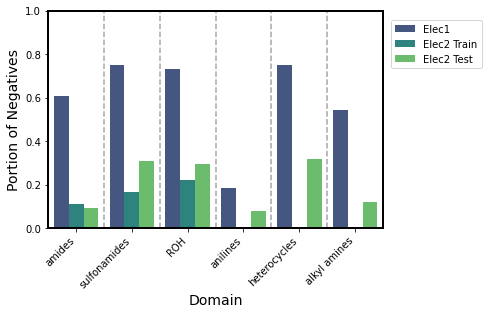

In [4]:
### Figure S3
inds_by_nuc = split_by_elec(full_id)
plot_neg_portion(full_yield, inds_by_nuc, save=False)

In [5]:
if os.path.exists("./array_joblibs/source_id_dict.joblib"):
    source_id_dict = joblib.load("./array_joblibs/source_id_dict.joblib")
    source_desc_dict = joblib.load("./array_joblibs/source_desc_dict.joblib")
    source_y_dict = joblib.load("./array_joblibs/source_y_dict.joblib")
    target_id_dict = joblib.load("./array_joblibs/target_id_dict.joblib")
    target_desc_dict = joblib.load("./array_joblibs/target_desc_dict.joblib")
    target_y_dict = joblib.load("./array_joblibs/target_y_dict.joblib")
else : 
    source_id_dict, source_desc_dict, source_y_dict,\
    target_id_dict, target_desc_dict, target_y_dict = prep_arrays(full_id, full_desc, full_yield,
                inds_by_nuc)
    joblib.dump(source_id_dict, "./array_joblibs/source_id_dict.joblib")
    joblib.dump(source_desc_dict, "./array_joblibs/source_desc_dict.joblib")
    joblib.dump(source_y_dict, "./array_joblibs/source_y_dict.joblib")
    joblib.dump(target_id_dict, "./array_joblibs/target_id_dict.joblib")
    joblib.dump(target_desc_dict, "./array_joblibs/target_desc_dict.joblib")
    joblib.dump(target_y_dict, "./array_joblibs/target_y_dict.joblib")

if os.path.exists("./array_joblibs/source_fp_dict.joblib"):
    print("Loaded arrays.")
    source_fp_dict = joblib.load("./array_joblibs/source_fp_dict.joblib")
    target_fp_dict = joblib.load("./array_joblibs/target_fp_dict.joblib")
else :
    print("Preparing arrays.")
    source_fp_dict = prep_fp_arrays(source_id_dict)
    target_fp_dict = prep_fp_arrays(target_id_dict)
    joblib.dump(source_fp_dict, "./array_joblibs/source_fp_dict.joblib")
    joblib.dump(target_fp_dict, "./array_joblibs/target_fp_dict.joblib")

Loaded arrays.


In [6]:
### Arranging arrays so that all-pairwise transfer can be done.
### Originally only target domains
for domain in ["anilines", "alkyl amines", "heterocycles"]:
    source_id_array = np.vstack((source_id_dict[domain], target_id_dict[domain][:18,:]))
    source_desc_array = np.vstack((source_desc_dict[domain], target_desc_dict[domain][:18,:]))
    source_fp_array = np.vstack((source_fp_dict[domain], target_fp_dict[domain][:18,:]))
    source_y_array = np.concatenate((source_y_dict[domain], target_y_dict[domain][:18]))
    
    source_id_dict[domain] = source_id_array
    source_desc_dict[domain] = source_desc_array
    source_fp_dict[domain] = source_fp_array
    source_y_dict[domain] = source_y_array
    
### Originally only source domains
old_source_id_dict = joblib.load("./array_joblibs/source_id_dict.joblib")
old_source_desc_dict = joblib.load("./array_joblibs/source_desc_dict.joblib")
old_source_fp_dict = joblib.load("./array_joblibs/source_fp_dict.joblib")
old_source_y_dict = joblib.load("./array_joblibs/source_y_dict.joblib")

for i, domain in enumerate(["amides", "sulfonamides", "ROH"]):
    if i < 2 :
        x = 20
    else :
        x = 24
    no_solv3_id = target_id_dict[domain][:-x, :]
    no_solv3_desc = target_desc_dict[domain][:-x, :]
    no_solv3_fp = target_fp_dict[domain][:-x, :]
    no_solv3_y = target_y_dict[domain][:-x]
    
    new_target_id = np.vstack((no_solv3_id, old_source_id_dict[domain][-18:,:]))
    new_target_desc = np.vstack((no_solv3_desc, old_source_desc_dict[domain][-18:,:]))
    new_target_fp = np.vstack((no_solv3_fp, old_source_fp_dict[domain][-18:,:]))
    new_target_y = np.concatenate((no_solv3_y, old_source_y_dict[domain][-18:]))
    
    target_id_dict[domain] = new_target_id
    target_desc_dict[domain] = new_target_desc
    target_fp_dict[domain] = new_target_fp
    target_y_dict[domain] = new_target_y
    
source_oh_dict = prep_onehot_arrays(source_id_dict)

In [7]:
# Now all domains have the same 82 reaction conditions
for k, v in source_id_dict.items() :
    print(k, v.shape, source_desc_dict[k].shape, source_y_dict[k].shape)

amides (82, 5) (82, 73) (82,)
sulfonamides (82, 5) (82, 73) (82,)
ROH (82, 5) (82, 73) (82,)
heterocycles (82, 5) (82, 73) (82,)
alkyl amines (82, 5) (82, 73) (82,)
anilines (82, 5) (82, 73) (82,)


In [8]:
# Now all target domains have the similar number of reactions ~43
# Aniline, alkyl amines, heterocycles have [Cat 1, 2, 8, 10, 11] x [Solv 1] &
#                                          [Cat 1, 2, 8, 10, 11, 15] x [Solv 2], cat 15 lacks one comb --> 44-1
# While Amide and Sulfonamide have         [Cat 1, 2, 8, 10, 15] x [Solv 1] & 
#                                          [Cat 1, 2, 8, 10, 15] x [Solv 2]
# and ROH has                              [Cat 1, 2, 3, 7, 8, 15] x [Solv 1] &
#                                          [Cat 1, 2, 3, 7, 8, 15] x [Solv 2]
for k, v in target_id_dict.items() :
    print(k, v.shape, target_desc_dict[k].shape, target_y_dict[k].shape)

amides (40, 5) (40, 73) (40,)
sulfonamides (40, 5) (40, 73) (40,)
ROH (48, 5) (48, 73) (48,)
heterocycles (43, 5) (43, 73) (43,)
alkyl amines (43, 5) (43, 73) (43,)
anilines (43, 5) (43, 73) (43,)


In [249]:
joblib.dump(source_id_dict, "./array_joblibs/final_source_id_dict.joblib")
joblib.dump(source_desc_dict, "./array_joblibs/final_source_desc_dict.joblib")
joblib.dump(source_y_dict, "./array_joblibs/final_source_y_dict.joblib")
joblib.dump(target_id_dict, "./array_joblibs/final_target_id_dict.joblib")
joblib.dump(target_desc_dict, "./array_joblibs/final_target_desc_dict.joblib")
joblib.dump(target_y_dict, "./array_joblibs/final_target_y_dict.joblib")

['./array_joblibs/final_target_y_dict.joblib']

In [18]:
DEPTH_LIST = [1,2,3,5,None]
NUM_TREE_LIST = [1,3,5,10,20,50,100,200]

def screen_all_params_and_targets(
    source, source_X_dict, source_y_dict, target_X_dict, target_y_dict,
    domains=DOMAINS, depth_list=DEPTH_LIST, num_tree_list=NUM_TREE_LIST, n_random_states=25,
    shuffle=False
):
    """ For a single source domain, conduct transfer for all remaining target domains
    with all pairs of depth and number of trees. """
    source_ind = domains.index(source)
    roc_auc_vals = []
    for _ in range(len(domains)):
        roc_auc_vals.append(np.zeros((len(depth_list), len(num_tree_list), n_random_states)))

    for x in tqdm(range(n_random_states)):
        for a, depth in enumerate(depth_list):
            for b, num_trees in enumerate(num_tree_list):
                rfc = RandomForestClassifier(random_state=42+x)
                param_grid = {"max_depth":[depth],
                              "n_estimators":[num_trees]}

                grid_rfc = GridSearchCV(rfc, 
                                        param_grid=param_grid,
                                        scoring="roc_auc", cv=5)
                if not shuffle : 
                    grid_rfc.fit(source_X_dict[source], source_y_dict[source])
                if shuffle :
                    np.random.seed(x)
                    y_shuffled = deepcopy(source_y_dict[source])
                    np.random.shuffle(y_shuffled)
                    grid_rfc.fit(source_X_dict[source], y_shuffled)
                roc_auc_vals[source_ind][a, b, x] = grid_rfc.best_score_

                for j, target in enumerate(domains) :
                    if j!=source_ind :
                        roc_auc_vals[j][a, b, x] = roc_auc_score(
                            target_y_dict[target],
                            grid_rfc.predict_proba(target_X_dict[target])[:,1]
                        )
        
    return roc_auc_vals


def prep_heatmap(score_array, depth_list, num_tree_list, 
                 fig_num, source, target, std=True, vmin=0.5, vmax=1, cbar=False):
    ''' Plots heatmaps of performances at different levels.
    
    Parameters
    ----------
    score_array : np.2darray
        output of function above.
    depth_list, num_tree_list : list of ints
        inputs used throughout.
        
    Returns
    -------
    None
    '''
    xlen = len(num_tree_list) -1
    ylen = len(depth_list) - 1
    fig, ax = plt.subplots(figsize=(xlen,ylen))
    avg_score = np.mean(score_array,axis=2)
    annot_labels = [[0]*avg_score.shape[1] for x in range(avg_score.shape[0])]
    if std:
        std_score = np.std(score_array, axis=2)
        for i in range(avg_score.shape[0]):
            for j in range(avg_score.shape[1]):
                if round(std_score[i,j],2) >= 0.01 : 
                    avg_std = f"{round(avg_score[i,j],2)}\n({round(std_score[i,j],2)})"
                else : 
                    avg_std = f"{round(avg_score[i,j],2)}"
                annot_labels[i][j] = avg_std
    else :
        for i in range(avg_score.shape[0]):
            for j in range(avg_score.shape[1]):
                annot_labels[i][j] = round(avg_score[i,j],2)
    sns.heatmap(avg_score, cmap='viridis', cbar=cbar, square=True,
                vmin=vmin, vmax=vmax, annot=annot_labels, fmt='')
    ax.set_yticklabels([str(x) for x in depth_list], 
                       verticalalignment="center")
    ax.set_ylabel("Maximum Depth of Trees", fontsize=14)
    ax.set_xticklabels(num_tree_list)
    ax.set_xlabel("Number of Trees", fontsize=14)
    if fig_num is not None:
        fig.savefig(f"./figures/{fig_num}_{source}_{target}.pdf",
                            dpi=300, format="pdf", bbox_inches="tight")
        

def run_ttest(score_array, ind1, ind2, equal_var=True):
    """ Runs t-test to compare two models.
    
    Parameters
    ----------
    score_array : ndarray of shape (depth, n_trees, n_models)
        Raw array of roc-auc scores.
        
    ind1, ind2 : tuple of ints (row_ind, col_ind)
        Coordinates of the array to compare.
        
    equal_var : bool
        Whether the variance is expected to be the same.
        
    Returns
    -------
    p : float
        Value of t.
    """
    score_array1 = score_array[ind1[0], ind1[1], :]
    score_array2 = score_array[ind2[0], ind2[1], :]
    t, p = ttest_ind(score_array1, score_array2, equal_var=equal_var)
    return p


def ttest_over_arrays(array_to_screen, standard_ind):
    """ Within a single array, do t-tests between a standard cell and all remaining other cells.
    
    Parameters
    ----------
    array_to_screen : 3darray of shape (n_depths, n_trees, n_random_states)
        ROC-AUC array to screen through.
        
    standard_ind : tuple
        the indices along the first two axes.
    
    Returns
    -------
    t_array : 2darray of shape (n_depths, n_trees)
        p-values resulting from two-sided t-tests.
    """
    t_array = np.ones_like(array_to_screen[:,:,0])
    for i in range(array_to_screen.shape[0]):
        for j in range(array_to_screen.shape[1]) :
            if (i,j) != (standard_ind) :
                _, p = ttest_ind(
                    array_to_screen[i,j,:], 
                    array_to_screen[standard_ind[0], standard_ind[1], :], 
                    equal_var=False
                )
                t_array[i,j] = p
    return t_array


def ttest_over_list_of_arrays(list_of_arrays_to_screen, list_of_standard_inds, domains=DOMAINS):
    """ For all pairs of source, target array, conduct t-test between
    best CV score and best of simplified model's score. """
    roc_auc_diff = np.zeros((len(domains), len(domains)))
    t_array = np.zeros_like(roc_auc_diff)
    for i in range(len(domains)):
        for j in range(len(domains)):
            if j!=i :
                cv_transfer_score_array = list_of_arrays_to_screen[i][j][list_of_standard_inds[i][i][0], list_of_standard_inds[i][i][1], :]
                simplified_model_score_array = list_of_arrays_to_screen[i][j][list_of_standard_inds[i][j][0], list_of_standard_inds[i][j][1], :]
                _, p = ttest_ind(
                    cv_transfer_score_array,
                    simplified_model_score_array,
                    equal_var=False
                )
                t_array[i, j] = p
                roc_auc_diff[i, j] = np.mean(simplified_model_score_array) - np.mean(cv_transfer_score_array)
    return roc_auc_diff, t_array


def plot_significance_and_which_model_scores_higher(
        roc_auc_diff, t_array,
        domains=DOMAINS,
        filename=None
    ):
    ''' On a grid-table, show whether a particular source-target pair
    • favors simplified model over CV-determined model.
    • scores are statistically different. '''
    
    fig, ax = plt.subplots()
    for i, source in enumerate(domains):
        for j, target in enumerate(domains):
            if i!=j :
                if t_array[i,j] < 0.05 :
                    marker = "o"
                else :
                    marker = "x"
                if roc_auc_diff[i,j] >= 0 :
                    color = "#29AF7F"
                    size = roc_auc_diff[i,j]*5000
                else : 
                    color = "#453781"
                    size = roc_auc_diff[i,j]*-5000
                scatter = ax.scatter(y=6-i,
                           x=j+1, s=size,
                           c=color,
                           marker=marker)
    ax.set_yticks([x+1 for x in range(6)])
    ax.set_ylim(0.5, 6.5)
    ax.set_ylabel("Source Nucleophile", fontsize=14)
    ax.set_yticklabels(domains[::-1])
    ax.set_xlim(0.5, 6.5)
    ax.set_xticklabels([""]+domains)
    ax.set_xlabel("Target Nucleophile", fontsize=14)
    ax.tick_params(axis='x', rotation=90)
    
    for j in range(6):
        ax.axvline(j+1.5, 0, 1, c="grey")
        ax.axhline(j+1.5, 0, 1, c="grey")

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    
    color_legend_elements = [
        Line2D([0], [0], color="#29AF7F", label="Simplified"), #alpha=0.6
        Line2D([0], [0], color="#453781", label="CV"),
    ]
    color_legend = ax.legend(handles=color_legend_elements,
                              bbox_to_anchor=(1.02, 0.78), title="Better Performance")
    plt.gca().add_artist(color_legend)
    
    size_legend_elements = [
        Line2D([0], [0], markerfacecolor="#29AF7F", marker='o', color="w", label="0.05",
               markersize=sqrt(0.05*5000), alpha=0.6),
        Line2D([0], [0], color="w"),
        Line2D([0], [0], markerfacecolor="#29AF7F", marker='o', color="w", label="0.10", 
               markersize=sqrt(0.1*5000), alpha=0.6),
        Line2D([0], [0], color="w"),
        Line2D([0], [0.5], markerfacecolor="#29AF7F", marker='o', color="w", label="0.15", 
               markersize=sqrt(0.15*5000), alpha=0.6),
        Line2D([0], [0], color="w"),
    ]
    size_legend = ax.legend(handles=size_legend_elements,
                              bbox_to_anchor=(1.02, 0.52), title="ROC-AUC Difference")
    plt.gca().add_artist(size_legend)

    kw = dict(prop="sizes", num=4, color='grey', )
     
    marker_elements = [
        Line2D([0], [0], markerfacecolor="grey", marker='o',
               color="w", label="Significant", markersize=10, alpha=0.6),
        Line2D([0], [0], markerfacecolor="grey", marker='x',
               color="none", label="Insignificant", markersize=10, alpha=0.6),
    ]
    ax.legend(handles=marker_elements,
              bbox_to_anchor=(1.02, 1.02), title="t-test")
    ax.set_aspect('equal')

    if filename is not None:
        fig.savefig(f"./figures/figure9_{filename}.pdf",
                    format="pdf", dpi=300, bbox_inches="tight")

def get_ind_of_max_mean(array):
    return np.unravel_index(
                np.argmax(np.mean(array, axis=2)), 
                array[:,:,0].shape
            )   

def trellis_of_adversarial_control(
    list_of_desc_roc, list_of_fp_roc, list_of_oh_roc,
    domains=DOMAINS
):
    ''' Prepares a 6x6 trellis plot of bar plots of ROC-AUC values from
    descriptor-, fingerprint- and onehot- based models.
    Also displays the Bonferroni corrected p-values. '''
    
    fig, ax = plt.subplots(len(list_of_desc_roc), len(list_of_desc_roc), figsize=(12,12), 
                           gridspec_kw={"wspace":0.1, "hspace":0.1})
    for i, source in enumerate(domains):
        for j, target in enumerate(domains):
            desc_inds = get_ind_of_max_mean(list_of_desc_roc[i][j])
            desc_scores = list_of_desc_roc[i][j][desc_inds[0], desc_inds[1], :]
            
            fp_inds = get_ind_of_max_mean(list_of_fp_roc[i][j])
            fp_scores = list_of_fp_roc[i][j][fp_inds[0], fp_inds[1], :]
            
            oh_inds = get_ind_of_max_mean(list_of_oh_roc[i][j])
            oh_scores = list_of_oh_roc[i][j][oh_inds[0], oh_inds[1], :]
            
            sns.barplot(
                x=["DFT"]*len(desc_scores)+["FP"]*len(fp_scores)+["OneHot"]*len(oh_scores),
                y = np.concatenate((desc_scores, fp_scores, oh_scores)),
                ci = "sd",
                ax = ax[i,j]
            )
            ax[i,j].set_ylim([0.5,1])
            ax[i,j].set_yticks([0.5,0.75,1])
            ax[i,j].set_yticklabels([0.5,0.75,1])
            
            if j > 0 : 
                ax[i,j].set_ylabel('')
                ax[i,j].set_yticklabels([])
            else :
                ax[i,j].set_ylabel(f"{domains[i]}", fontsize=12)
            if i < len(list_of_desc_roc)-1 :
                ax[i,j].set_xticklabels([])
            else : 
                ax[i,j].set_xlabel(f"{domains[j]}", fontsize=12)
                
            _, p_desc_fp = ttest_ind(desc_scores, fp_scores, equal_var=False)
            _, p_desc_oh = ttest_ind(desc_scores, oh_scores, equal_var=False)
            _, p_fp_oh = ttest_ind(fp_scores, oh_scores, equal_var=False)
            
            pal = sns.color_palette()
            colors = pal.as_hex()

            best_score_feature = np.argmax(np.array([np.mean(desc_scores), np.mean(fp_scores), np.mean(oh_scores)]))
            if best_score_feature == 0 :
                coord = (0, 0.55)
                if p_desc_fp < 0.001/3 and p_desc_oh < 0.001/3 :
                    sig = "***"
                elif p_desc_fp < 0.01/3 and p_desc_oh < 0.01/3 :
                    sig = "**"
                elif p_desc_fp < 0.05/3 and p_desc_oh < 0.05/3 :
                    sig = "*"
                else : 
                    sig = " "
            elif best_score_feature == 1 :
                coord = (1, 0.55)
                if p_desc_fp < 0.001/3 and p_fp_oh < 0.001/3 :
                    sig = "***"
                elif p_desc_fp < 0.05/3 and p_fp_oh < 0.05/3 :
                    sig = "**"
                elif p_desc_fp < 0.05/3 and p_fp_oh < 0.05/3 :
                    sig = "*"
                else : 
                    sig = " "
            else : 
                coord = (2, 0.55)
                if p_desc_oh < 0.001/3 and p_fp_oh < 0.001/3 :
                    sig = "***"
                elif p_desc_oh < 0.01/3 and p_fp_oh < 0.01/3 :
                    sig = "**"
                elif p_desc_oh < 0.05/3 and p_fp_oh < 0.05/3 :
                    sig = "*"
                else : 
                    sig = " "
            ax[i,j].annotate(sig, xy=coord, xytext=coord, color="white", ha="center", fontsize=12, fontweight="bold")
#             if edge_col != "black":
#                 for axis in ['top', 'bottom', 'left', 'right']:
#                     ax[i,j].spines[axis].set_linewidth(4)
#                     ax[i,j].spines[axis].set_edgecolor(edge_col)
                    
                    
def get_desc_vs_fp_roc_diffs(list_of_desc_roc, list_of_fp_roc, list_of_oh_roc, domains=DOMAINS):
    dict_to_plot = {"ROC-AUC Diff.":[], "Feature":[]}
    for i, source in enumerate(domains):
        for j, target in enumerate(domains) :
            if i!=j :
                desc_inds = get_ind_of_max_mean(list_of_desc_roc[i][j])
                desc_scores = list_of_desc_roc[i][j][desc_inds[0], desc_inds[1], :]

                fp_inds = get_ind_of_max_mean(list_of_fp_roc[i][j])
                fp_scores = list_of_fp_roc[i][j][fp_inds[0], fp_inds[1], :]

                oh_inds = get_ind_of_max_mean(list_of_oh_roc[i][j])
                oh_scores = list_of_oh_roc[i][j][oh_inds[0], oh_inds[1], :]
                
                _, p_desc_fp = ttest_ind(desc_scores, fp_scores, equal_var=False)
                _, p_desc_oh = ttest_ind(desc_scores, oh_scores, equal_var=False)
                _, p_fp_oh = ttest_ind(fp_scores, oh_scores, equal_var=False)
                
                best_score_feature = np.argmax(np.array([np.mean(desc_scores), np.mean(fp_scores), np.mean(oh_scores)]))
                if best_score_feature == 0 :
                    if p_desc_fp < 0.05/3 and p_desc_oh < 0.05/3 :
                        dict_to_plot["ROC-AUC Diff."].append(np.mean(desc_scores) - np.mean(fp_scores))
                        dict_to_plot["Feature"].append("Desc")
                elif best_score_feature == 1 :
                    if p_desc_fp < 0.05/3 and p_fp_oh < 0.05/3 :
                        dict_to_plot["ROC-AUC Diff."].append(np.mean(fp_scores)-np.mean(desc_scores))
                        dict_to_plot["Feature"].append("FP")
    fig, ax = plt.subplots(figsize=(4,4))
    sns.swarmplot(x="Feature", y="ROC-AUC Diff.", data=dict_to_plot, ax=ax)
    ax.set_ylim([0, 0.3])
    ax.set_ylabel("Difference in ROC-AUC", fontsize=14)
    ax.set_xlabel("Better Performing Feature", fontsize=14)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

In [10]:
if not os.path.exists("./array_joblibs/all_complexity_vs_transfer.joblib") :
    all_desc_transfer_roc = []
    for source in DOMAINS :
        desc_roc = screen_all_params_and_targets(
            source, source_desc_dict, source_y_dict, target_desc_dict, target_y_dict
        )
        all_desc_transfer_roc.append(desc_roc)
    joblib.dump(all_desc_transfer_roc, "./array_joblibs/all_complexity_vs_transfer.joblib")
else :
    print("Loading existing scores.")
    all_desc_transfer_roc = joblib.load("./array_joblibs/all_complexity_vs_transfer.joblib")

Loading existing scores.


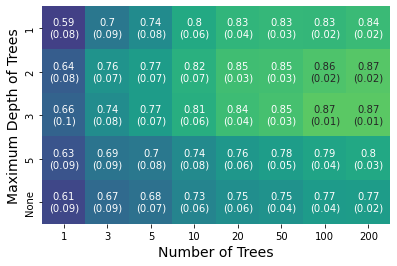

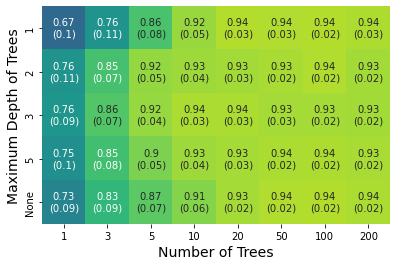

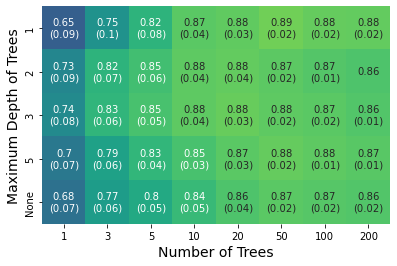

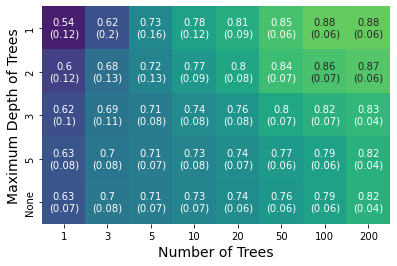

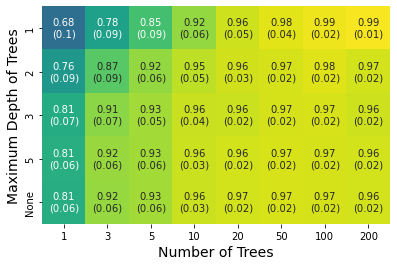

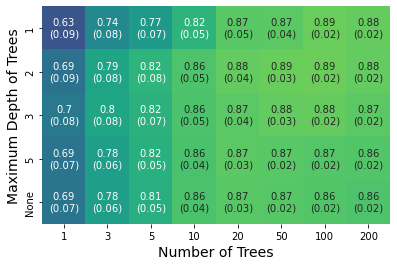

In [35]:
# In-Domain Cross Validation
for i in range(6):
    prep_heatmap(all_desc_transfer_roc[i][i], DEPTH_LIST, NUM_TREE_LIST, 
                 None, domains[i], "CV")

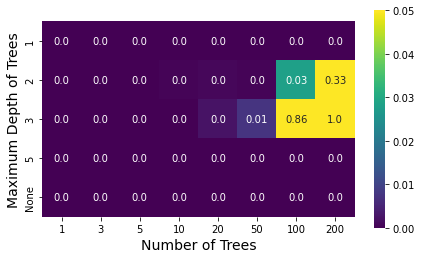

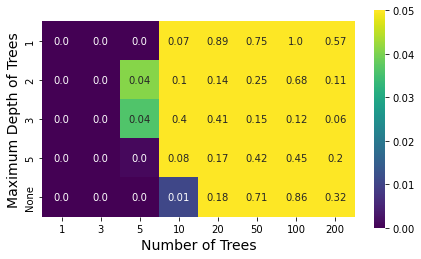

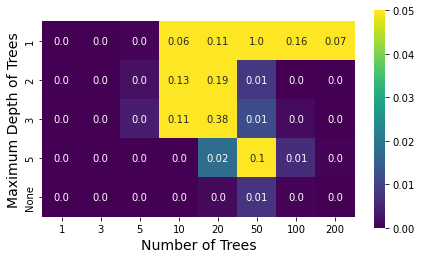

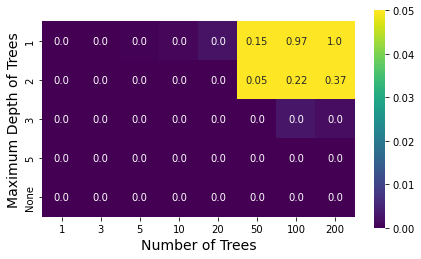

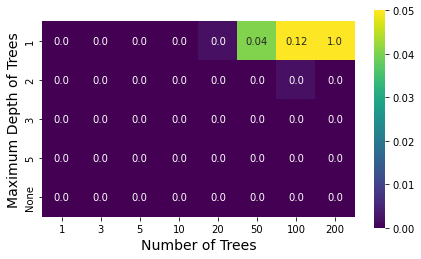

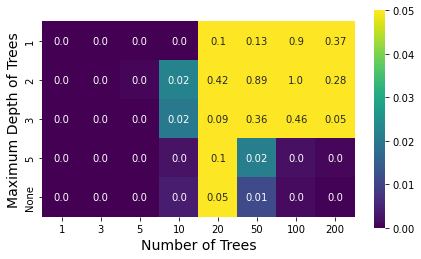

In [18]:
### Identifying which hyperparameter combinations have statistically lower scores.

CV_t_arrays = []
standard_ind_list = []
for i in range(6):
    max_inds = np.unravel_index(
        np.argmax(np.mean(all_desc_transfer_roc[i][i], axis=2)),
        all_desc_transfer_roc[i][i][:,:,0].shape
    )
    standard_ind_list.append(max_inds)

for i in range(6):
    t_array = ttest_over_arrays(all_desc_transfer_roc[i][i], standard_ind_list[i])
    prep_heatmap(t_array.reshape(t_array.shape[0], t_array.shape[1], 1), DEPTH_LIST, NUM_TREE_LIST, 
                 None, DOMAINS[i], "t-test", False, vmin=0, vmax=0.05, cbar=True)
    CV_t_arrays.append(t_array)

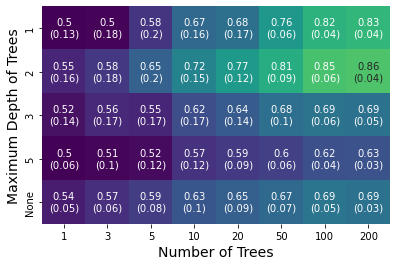

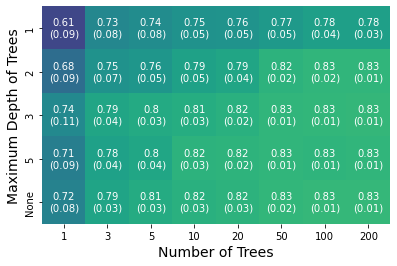

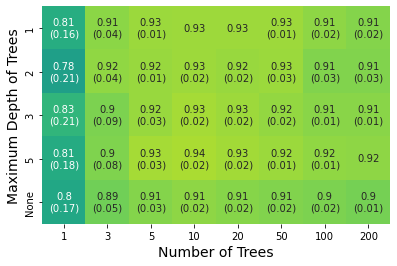

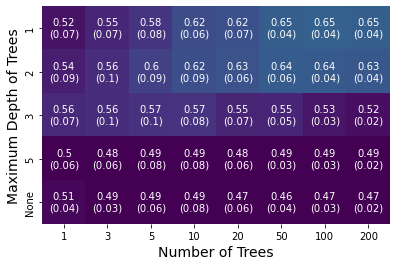

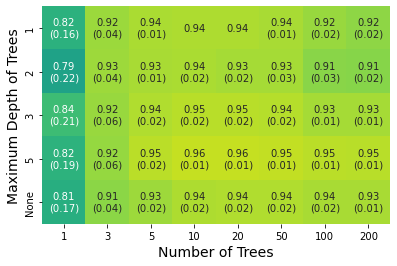

In [38]:
# Transfer
for i in [0]:
    for j in range(6):
        if j!=i :
            prep_heatmap(all_desc_transfer_roc[i][j], DEPTH_LIST, NUM_TREE_LIST, 
                     None, domains[i], "CV")

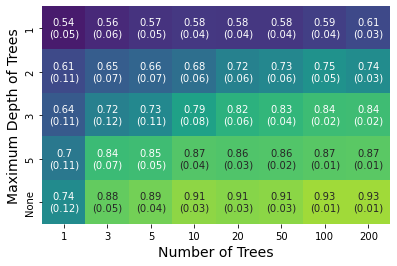

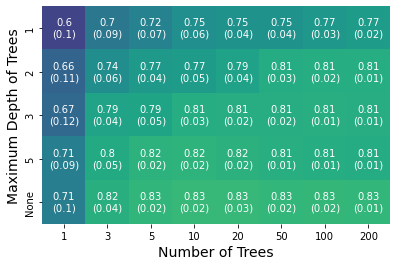

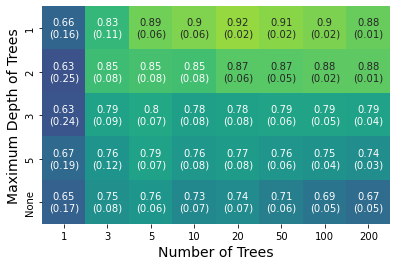

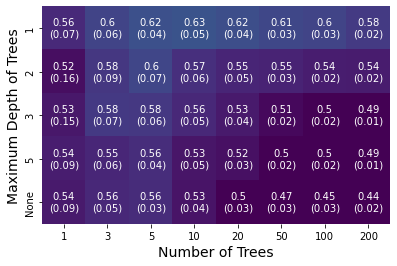

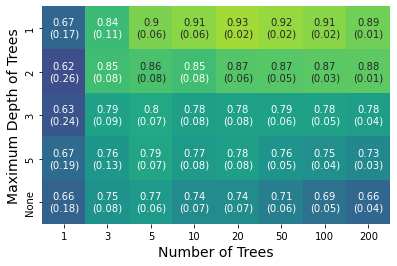

In [41]:
for i in [1]:
    for j in range(6):
        if j!=i :
            prep_heatmap(all_desc_transfer_roc[i][j], DEPTH_LIST, NUM_TREE_LIST, 
                     None, domains[i], "CV")

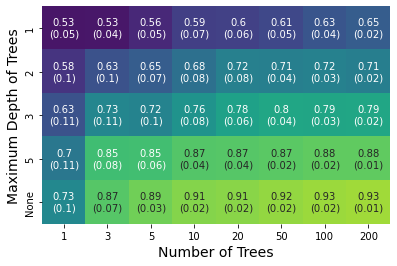

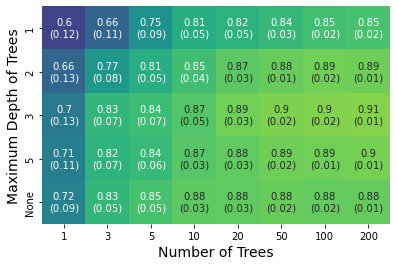

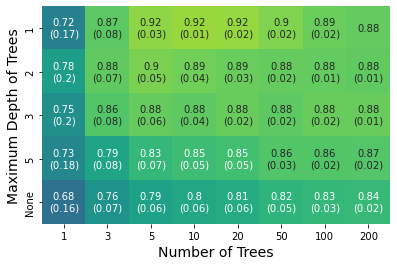

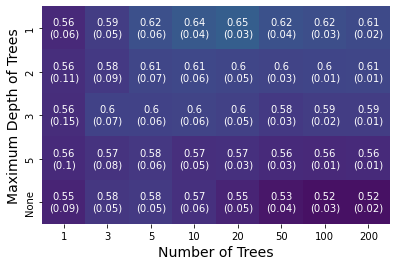

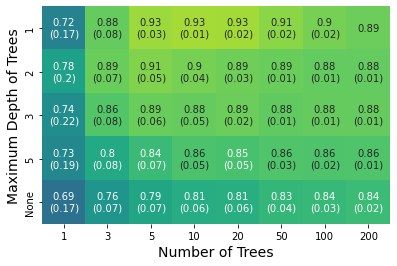

In [42]:
for i in [2]:
    for j in range(6):
        if j!=i :
            prep_heatmap(all_desc_transfer_roc[i][j], DEPTH_LIST, NUM_TREE_LIST, 
                     None, domains[i], "CV")

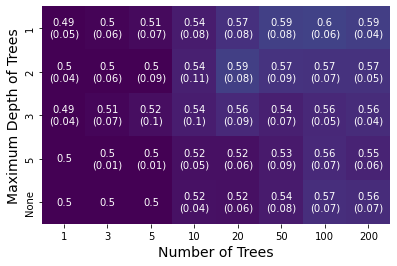

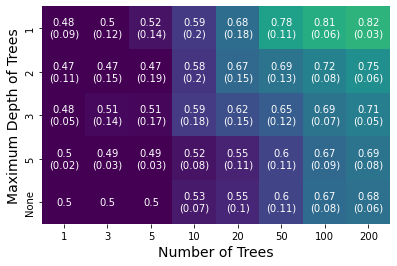

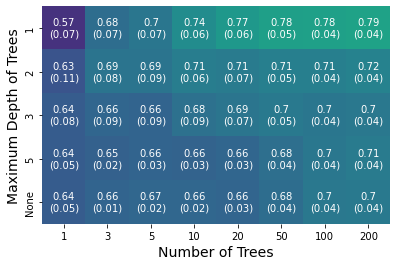

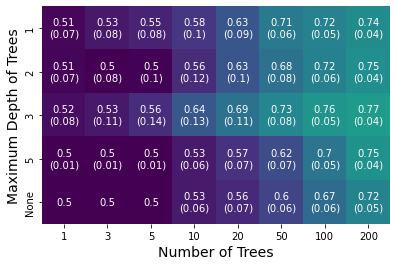

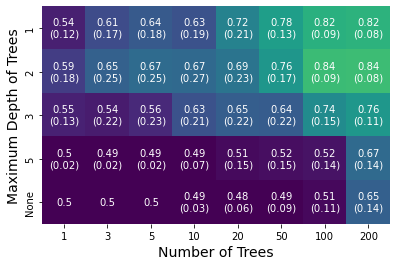

In [43]:
for i in [3]:
    for j in range(6):
        if j!=i :
            prep_heatmap(all_desc_transfer_roc[i][j], DEPTH_LIST, NUM_TREE_LIST, 
                     None, domains[i], "CV")

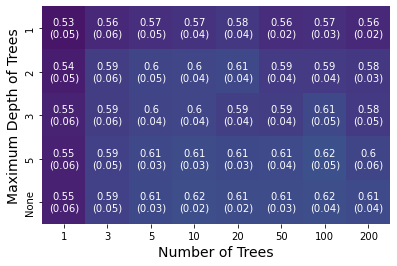

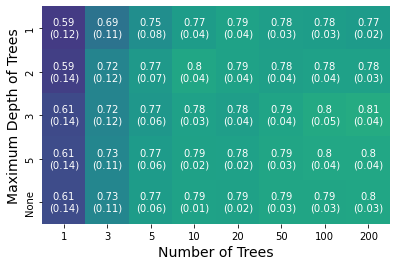

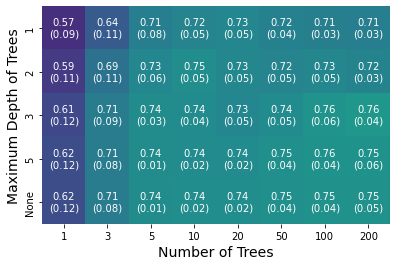

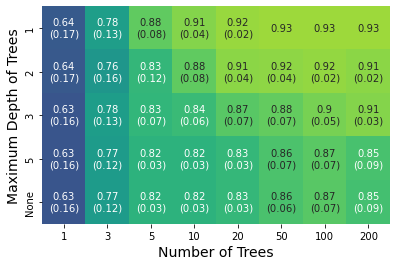

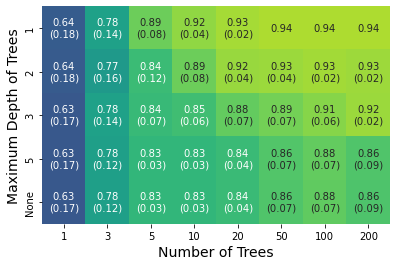

In [44]:
for i in [4]:
    for j in range(6):
        if j!=i :
            prep_heatmap(all_desc_transfer_roc[i][j], DEPTH_LIST, NUM_TREE_LIST, 
                     None, domains[i], "CV")

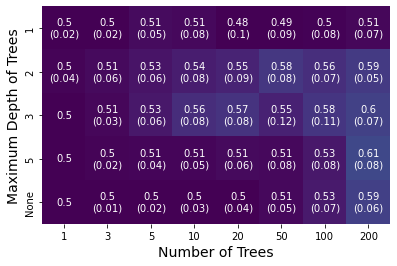

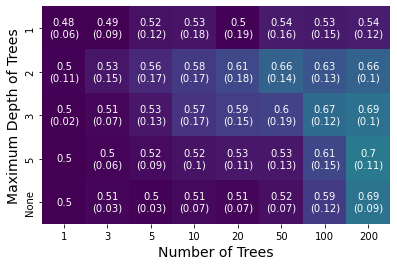

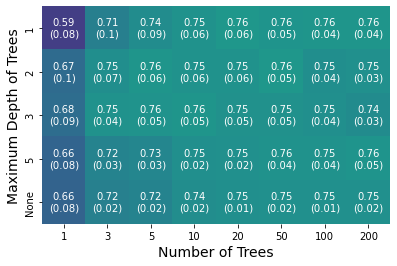

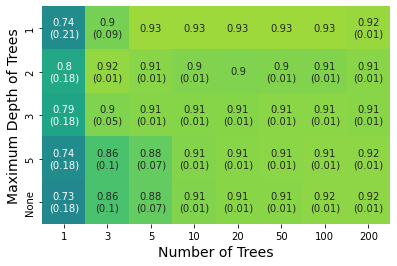

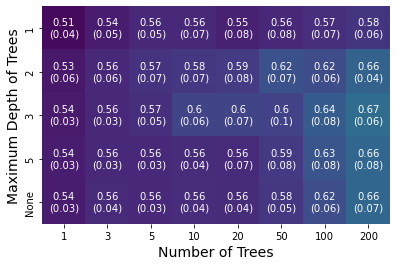

In [45]:
for i in [5]:
    for j in range(6):
        if j!=i :
            prep_heatmap(all_desc_transfer_roc[i][j], DEPTH_LIST, NUM_TREE_LIST, 
                     None, domains[i], "CV")

In [19]:
#
simplified_model_inds = np.array([
    [list(standard_ind_list[0]),[0,5],[1,5],[0,2],[0,3],[0,2]],
    [[1,1],list(standard_ind_list[1]),[2,1],[0,2],[0,2],[0,2]],
    [[2,1],[2,2],list(standard_ind_list[2]),[0,2],[0,2],[0,2]],
    [[1,4],[0,4],[0,4],list(standard_ind_list[3]),[0,4],[0,4]],
    [[1,2],[1,3],[1,3],[0,4],list(standard_ind_list[4]),[0,3]],
    [[1,3],[1,3],[1,2],[0,2],[1,2],list(standard_ind_list[5])],
])
cv_vs_simple_scores, cv_vs_simple_ttests = ttest_over_list_of_arrays(all_desc_transfer_roc, simplified_model_inds)

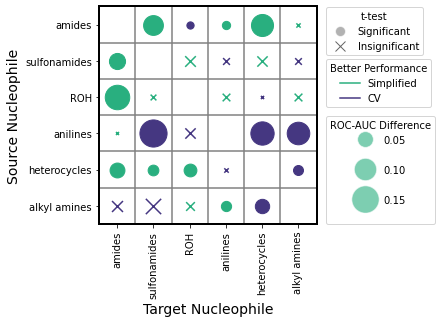

In [236]:
plot_significance_and_which_model_scores_higher(cv_vs_simple_scores, cv_vs_simple_ttests)

In [23]:
cv_scores = np.zeros(30)
simpler_scores = np.zeros(30)

count = 0
for i in range(6):
    for j in range(6):
        if i!=j :
            cv_scores[count] = np.mean(
                all_desc_transfer_roc[i][j][simplified_model_inds[i][i][0], simplified_model_inds[i][i][1], :]
            )
            simpler_scores[count] = np.mean(
                all_desc_transfer_roc[i][j][simplified_model_inds[i][j][0], simplified_model_inds[i][j][1], :]
            )
            count += 1

_, p = wilcoxon(cv_scores, simpler_scores)
print(p)

0.5577426862039239


# Adversarial Controls

### Fingerprints

In [11]:
if not os.path.exists("./array_joblibs/FP_transfer.joblib") :
    # takes about 1h
    all_fp_transfer_roc = []
    for source in DOMAINS :
        fp_roc = screen_all_params_and_targets(
            source, source_fp_dict, source_y_dict, target_fp_dict, target_y_dict
        )
        all_fp_transfer_roc.append(fp_roc)
    joblib.dump(all_fp_transfer_roc, "./array_joblibs/FP_transfer.joblib")
else :
    print("Loading existing.")
    all_fp_transfer_roc = joblib.load("./array_joblibs/FP_transfer.joblib")

Loading existing.


### OneHots

In [12]:
if not os.path.exists("./array_joblibs/OH_transfer.joblib") :
    # takes about 53min
    all_oh_transfer_roc = []
    for source in DOMAINS :
        # First need to split the onehot array and encoder
        source_oh = source_oh_dict[source][0]
        ohe = source_oh_dict[source][1]
        # Then transform all target arrays accordingly
        target_oh_dict = {}
        for target in DOMAINS : 
            if target!=source :
                target_id_array = target_id_dict[target]
                target_oh_dict.update({target:ohe.transform(target_id_array)})
        oh_roc = screen_all_params_and_targets(
            source, {source:source_oh}, source_y_dict, target_oh_dict, target_y_dict
        )
        all_oh_transfer_roc.append(oh_roc)
    joblib.dump(all_oh_transfer_roc, "./array_joblibs/OH_transfer.joblib")
else :
    print("Loading existing.")
    all_oh_transfer_roc = joblib.load("./array_joblibs/OH_transfer.joblib")

Loading existing.


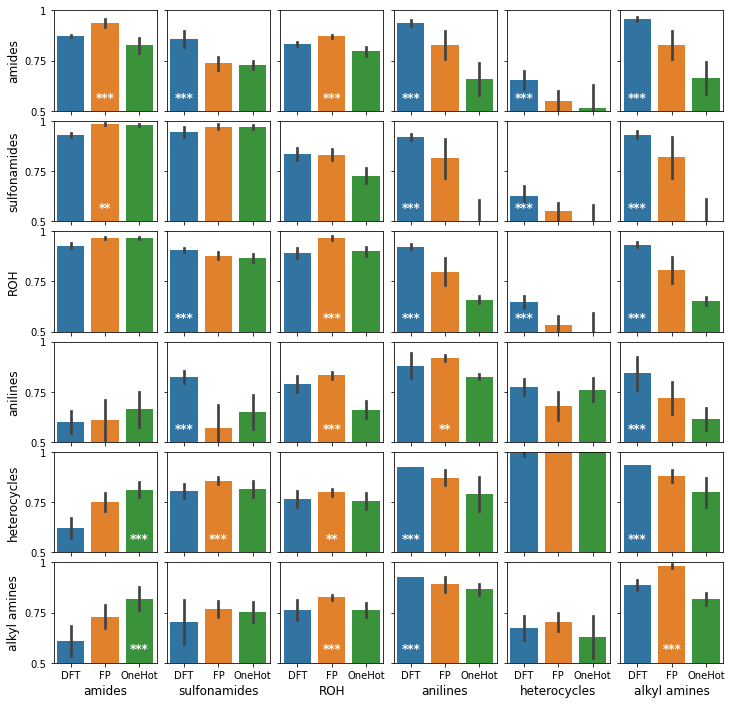

In [19]:
trellis_of_adversarial_control(all_desc_transfer_roc, all_fp_transfer_roc, all_oh_transfer_roc)

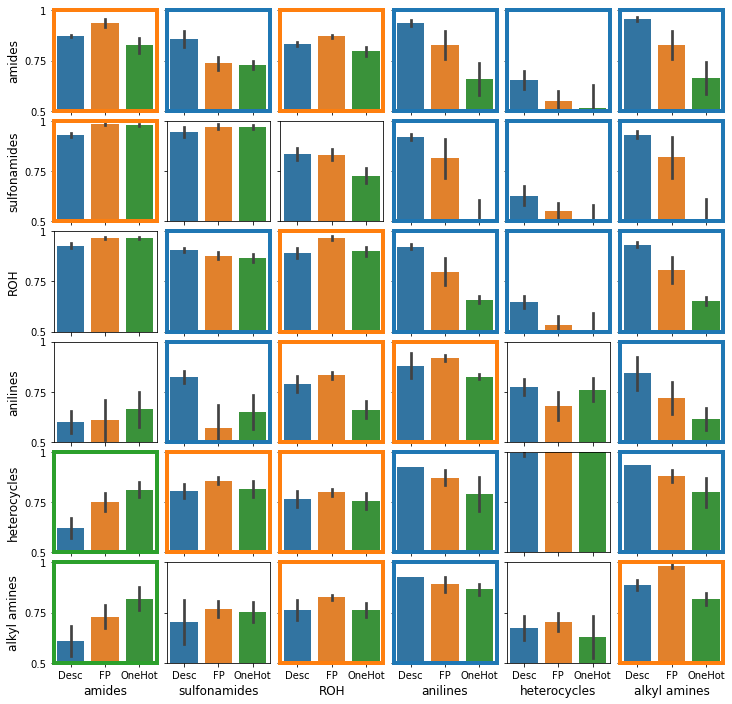

In [183]:
trellis_of_adversarial_control(all_desc_transfer_roc, all_fp_transfer_roc, all_oh_transfer_roc)

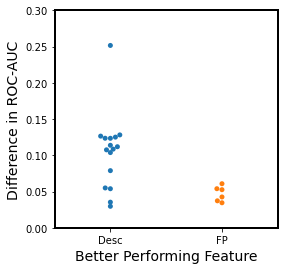

In [209]:
get_desc_vs_fp_roc_diffs(all_desc_transfer_roc, all_fp_transfer_roc, all_oh_transfer_roc)

### Y-Shuffling

In [191]:
if not os.path.exists("./array_joblibs/all_shuffled_roc.joblib") :
    all_shuffled_roc = []
    
    for i, source in enumerate(DOMAINS) :
        shuffled_roc = screen_all_params_and_targets(
            source, source_desc_dict, source_y_dict, target_desc_dict, target_y_dict,
            shuffle=True
        )
        
        all_shuffled_roc.append(shuffled_roc)
    joblib.dump(all_shuffled_roc, "./array_joblibs/all_shuffled_roc.joblib")
else :
    all_shuffled_roc = joblib.load("./array_joblibs/all_shuffled_roc.joblib")

In [245]:
p_val_array = np.zeros((6,6))
annot = []
for i in range(6):
    annot.append([])
    for j in range(6):
        desc_max_ind = np.unravel_index(
            np.argmax(np.mean(all_desc_transfer_roc[i][j], axis=2)), 
            all_desc_transfer_roc[i][j][:,:,0].shape
        )
        shuffle_max_ind = np.unravel_index(
            np.argmax(np.mean(all_shuffled_roc[i][j], axis=2)), 
            all_shuffled_roc[i][j][:,:,0].shape
        )
        
        _, p = ttest_ind(
            all_desc_transfer_roc[i][j][desc_max_ind[0], desc_max_ind[1], :],
            all_shuffled_roc[i][j][shuffle_max_ind[0], shuffle_max_ind[1], :],
            equal_var=False
        )
        p_val_array[i,j] = p
        if p >= 0.001 :
            annot[i].append(round(p,3))
        else :
            annot[i].append("")

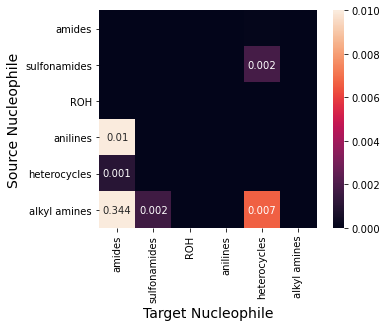

In [246]:
fig, ax = plt.subplots()
sns.heatmap(p_val_array, vmax=0.01, square=True, annot=annot, fmt="s")
ax.set_yticklabels(DOMAINS)
ax.set_xticklabels(DOMAINS)

ax.set_ylabel("Source Nucleophile", fontsize=14)
ax.set_yticklabels(DOMAINS)
ax.tick_params(axis='y', rotation=0)
ax.set_xticklabels(DOMAINS)
ax.set_xlabel("Target Nucleophile", fontsize=14)
ax.tick_params(axis='x', rotation=90)